In [9]:
import pandas as pd
import numpy as np
import os
from huggingface_hub import hf_hub_download
from poi.settings import HF_ORG, HF_TOKEN

# Configuration
target_path = 'TKY'  # 'NYC' or 'TKY'
model_name = 'rqvae-tky-div0.25-commit0.25-lr5e-5'  # Change based on target_path and desired model

# Download codebook CSV from Hugging Face
repo_id = f"{HF_ORG}/{target_path.lower()}"
codebook_filename = f"codebooks-{model_name}.csv"
codebook_hf_path = f"LLM Dataset/Intermediate Files/{codebook_filename}"

print(f"📥 Downloading codebook from {repo_id}/{codebook_hf_path}")
codebook_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename=codebook_hf_path,
    token=HF_TOKEN
)
codebook = pd.read_csv(codebook_path)
codebook.rename(columns={'Pid': 'poi_id'}, inplace=True)
codebook['Codebook'] = codebook['Codebook'].apply(eval)

# Download poi_info.csv and catname_mapping.csv from Hugging Face
print(f"📥 Downloading poi_info and mappings from {repo_id}")
poi_info_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename="Intermediate Files/poi_info.csv",
    token=HF_TOKEN
)
catname_mapping_path = hf_hub_download(
    repo_id=repo_id,
    repo_type="dataset",
    filename="Intermediate Files/catname_mapping.csv",
    token=HF_TOKEN
)

# Load poi_info and mappings
poi_info = pd.read_csv(poi_info_path)
catname_mapping = pd.read_csv(catname_mapping_path)

# Create mapping dictionaries (reverse: Mapped_Catname -> Original_Catname)
cat_id_to_name = dict(zip(catname_mapping['Mapped_Catname'], catname_mapping['Original_Catname']))

# Prepare poi_info with renamed columns to match notebook expectations
poi_info_prep = poi_info[['Pid', 'Catname', 'Region']].copy()
poi_info_prep.rename(columns={
    'Pid': 'poi_id',
    'Catname': 'cat_id',  # This is already mapped ID
    'Region': 'region_id'  # This is already mapped ID
}, inplace=True)

# Add original catname using mapping
poi_info_prep['catname'] = poi_info_prep['cat_id'].map(cat_id_to_name)

# Merge codebook with poi_info
codebook = codebook.merge(poi_info_prep[['poi_id', 'cat_id', 'catname', 'region_id']], on='poi_id', how='left')

# 创建 cat_and_region 列，组合类别名称和区域ID
codebook['cat_and_region'] = codebook['catname'] + ' @ Region ' + codebook['region_id'].astype(str)

# 打印 codebook 的前5行，查看数据结构
print("\n📋 Codebook DataFrame 前5行数据:")
print("=" * 80)
print(codebook.head())
print("\n📋 列名:", codebook.columns.tolist())
print("📋 数据形状:", codebook.shape)
print("=" * 80 + "\n")

📥 Downloading codebook from comp5331poi/tky/LLM Dataset/Intermediate Files/codebooks-rqvae-tky-div0.25-commit0.25-lr5e-5.csv
📥 Downloading poi_info and mappings from comp5331poi/tky

📋 Codebook DataFrame 前5行数据:
   poi_id      Codebook                                             Vector  \
0       1   [2, 10, 61]  [-0.08501724898815155, 0.11895938217639923, 0....   
1       2  [33, 48, 11]  [-0.01313196960836649, -0.01638399437069893, 0...   
2       3  [53, 48, 17]  [-0.15613196790218353, -0.007642671465873718, ...   
3       4   [17, 61, 7]  [0.1762826293706894, 0.19935420155525208, 0.33...   
4       5  [33, 44, 44]  [0.010553216561675072, 0.020532771944999695, 0...   

   cat_id              catname  region_id                   cat_and_region  
0      57                 Bank         48                 Bank @ Region 48  
1     107        Train Station         55        Train Station @ Region 55  
2     133         Dessert Shop         48         Dessert Shop @ Region 48  
3      83  J

In [10]:
# ============================================================================
# 统计 codebook 第一层索引的出现频率（找出出现次数最多的索引）
# ============================================================================
print("\n📊 Codebook 第一层索引出现频率统计:")
print("=" * 60)
first_layer_indices = codebook['Codebook'].apply(lambda x: x[0] if len(x) > 0 else None)
# 按频率排序（出现次数从高到低）
frequency = first_layer_indices.value_counts().sort_values(ascending=False)

print(f"\n✅ 出现次数最多的前50个索引（按频率从高到低排序）:")
for idx, count in frequency.head(50).items():
    print(f"   索引 {idx}: {count:4d} 次")

print(f"\n💡 结论:")
print(f"   总共 {len(frequency)} 个不同的索引值")
print(f"   最常见的索引值: {frequency.index[0]} (出现 {frequency.iloc[0]} 次)")
print("=" * 60 + "\n")

# ============================================================================
# 统计排名前50的每个索引下，出现频率最高的前5个类别（包含区域信息）
# ============================================================================
print("\n📊 排名前50的每个索引下，出现频率最高的前5个类别+区域组合:")
print("=" * 80)
top_50_indices = frequency.head(50).index.tolist()
groups_dict_catname = {}
groups_dict_cat_region = {}

for rank, idx in enumerate(top_50_indices, 1):
    filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
    
    # 统计类别分布
    top_categories = filtered_df['catname'].value_counts().head(5)
    groups_dict_catname[idx] = top_categories.to_dict()
    
    # 统计类别+区域组合分布
    top_cat_region = filtered_df['cat_and_region'].value_counts().head(5)
    groups_dict_cat_region[idx] = top_cat_region.to_dict()
    
    print(f"\n排名 #{rank:2d}: 索引 {idx:2d} (共 {len(filtered_df):3d} 个 POI, 出现 {frequency[idx]:3d} 次)")
    print(f"  【类别分布】")
    for i, (cat, count) in enumerate(top_categories.items(), 1):
        print(f"    Top {i}: {cat:30s} - {count:3d} 次")
    print(f"  【类别+区域组合分布】")
    for i, (cat_reg, count) in enumerate(top_cat_region.items(), 1):
        print(f"    Top {i}: {cat_reg:50s} - {count:3d} 次")

print("\n" + "=" * 80 + "\n")


📊 Codebook 第一层索引出现频率统计:

✅ 出现次数最多的前50个索引（按频率从高到低排序）:
   索引 33:  434 次
   索引 45:  408 次
   索引 26:  363 次
   索引 47:  360 次
   索引 12:  340 次
   索引 58:  332 次
   索引 37:  302 次
   索引 8:  293 次
   索引 7:  284 次
   索引 59:  278 次
   索引 15:  269 次
   索引 2:  248 次
   索引 9:  245 次
   索引 11:  244 次
   索引 1:  224 次
   索引 6:  217 次
   索引 14:  211 次
   索引 21:  210 次
   索引 18:  200 次
   索引 31:  195 次
   索引 60:  192 次
   索引 49:  191 次
   索引 13:  180 次
   索引 32:  176 次
   索引 17:  165 次
   索引 44:  162 次
   索引 50:  149 次
   索引 4:  146 次
   索引 10:  131 次
   索引 29:  116 次
   索引 24:  112 次
   索引 52:  108 次
   索引 57:  107 次
   索引 53:  102 次
   索引 55:   69 次
   索引 5:   67 次
   索引 54:   11 次
   索引 35:    2 次
   索引 63:    2 次
   索引 36:    2 次
   索引 19:    2 次
   索引 56:    2 次
   索引 48:    1 次
   索引 30:    1 次
   索引 22:    1 次
   索引 16:    1 次
   索引 25:    1 次
   索引 43:    1 次
   索引 34:    1 次
   索引 28:    1 次

💡 结论:
   总共 64 个不同的索引值
   最常见的索引值: 33 (出现 434 次)


📊 排名前50的每个索引下，出现频率最高的前5个类别+区域组合:

排名 # 1: 索引 33 (共 4

In [41]:
# ============================================================================
# 随机挑选 4 个索引（threshold：最少出现50次）
# ============================================================================
import random

all_indices = [33, 45, 26, 47, 12, 58, 37, 8, 7, 59, 
               15, 2, 9, 11, 1, 6, 14, 21, 18, 31, 
               60, 49, 13, 32, 17, 44, 50, 4, 10, 29, 
               24, 52, 57, 53, 55, 5]

# random.seed(42)
selected_indices = random.sample(all_indices, k=4)

print("从所有索引中随机挑选的4个索引：")
for idx in selected_indices:
    print(f"索引 {idx}")

从所有索引中随机挑选的4个索引：
索引 4
索引 57
索引 32
索引 7


In [42]:
# 生成 group_1 到 group_4，使用随机挑选的4个索引
# 分别统计 catname 和 cat_and_region 的分布

print("=" * 80)
print(f"统计类别分布 (catname) - 使用索引: {selected_indices}")
print("=" * 80)

# 使用 Cell 2 中随机选择的索引
idx1, idx2, idx3, idx4 = selected_indices

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1)]
group_1_cat = filtered_df['catname'].value_counts().head(5)
group_1_cat = group_1_cat.to_dict()
print(f"\n索引 {idx1}: {group_1_cat}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx2)]
group_2_cat = filtered_df['catname'].value_counts().head(5)
group_2_cat = group_2_cat.to_dict()
print(f"索引 {idx2}: {group_2_cat}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx3)]
group_3_cat = filtered_df['catname'].value_counts().head(5)
group_3_cat = group_3_cat.to_dict()
print(f"索引 {idx3}: {group_3_cat}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx4)]
group_4_cat = filtered_df['catname'].value_counts().head(5)
group_4_cat = group_4_cat.to_dict()
print(f"索引 {idx4}: {group_4_cat}")

print("\n" + "=" * 80)
print(f"统计类别+区域组合分布 (cat_and_region) - 使用索引: {selected_indices}")
print("=" * 80)

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1)]
group_1_cat_reg = filtered_df['cat_and_region'].value_counts().head(5)
group_1_cat_reg = group_1_cat_reg.to_dict()
print(f"\n索引 {idx1}: {group_1_cat_reg}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx2)]
group_2_cat_reg = filtered_df['cat_and_region'].value_counts().head(5)
group_2_cat_reg = group_2_cat_reg.to_dict()
print(f"索引 {idx2}: {group_2_cat_reg}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx3)]
group_3_cat_reg = filtered_df['cat_and_region'].value_counts().head(5)
group_3_cat_reg = group_3_cat_reg.to_dict()
print(f"索引 {idx3}: {group_3_cat_reg}")

filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx4)]
group_4_cat_reg = filtered_df['cat_and_region'].value_counts().head(5)
group_4_cat_reg = group_4_cat_reg.to_dict()
print(f"索引 {idx4}: {group_4_cat_reg}")

# 为了后续绘图兼容性，保留使用 catname 的变量名
group_1 = group_1_cat_reg
group_2 = group_2_cat_reg
group_3 = group_3_cat_reg
group_4 = group_4_cat_reg

统计类别分布 (catname) - 使用索引: [4, 57, 32, 7]

索引 4: {'Convenience Store': 32, 'Road': 14, 'CafÃ©': 6, 'Japanese Restaurant': 6, 'College Academic Building': 5}
索引 57: {'Train Station': 29, 'Ramen /  Noodle House': 25, 'Subway': 22, 'Bar': 4, 'Japanese Restaurant': 4}
索引 32: {'Mall': 12, 'Department Store': 12, 'College Academic Building': 10, 'Electronics Store': 9, 'University': 9}
索引 7: {'Convenience Store': 34, 'Food & Drink Shop': 20, 'Road': 19, 'Fast Food Restaurant': 17, 'Japanese Restaurant': 17}

统计类别+区域组合分布 (cat_and_region) - 使用索引: [4, 57, 32, 7]

索引 4: {'Convenience Store @ Region 48': 5, 'Convenience Store @ Region 14': 3, 'Road @ Region 17': 3, 'Convenience Store @ Region 37': 3, 'Convenience Store @ Region 17': 3}
索引 57: {'Subway @ Region 48': 9, 'Train Station @ Region 48': 7, 'Ramen /  Noodle House @ Region 28': 4, 'Ramen /  Noodle House @ Region 48': 4, 'Train Station @ Region 28': 4}
索引 32: {'Electronics Store @ Region 28': 6, 'Hobby Shop @ Region 28': 4, 'Office @ Region 

['Fast Food Restaurant @ Region 48', 'Bridge @ Region 14', 'Japanese Restaurant @ Region 48', 'Convenience Store @ Region 7', 'Japanese Restaurant @ Region 17', 'Convenience Store @ Region 48', 'Convenience Store @ Region 14', 'Road @ Region 17', 'Convenience Store @ Region 37', 'Convenience Store @ Region 17', 'Subway @ Region 48', 'Train Station @ Region 48', 'Ramen /  Noodle House @ Region 28', 'Ramen /  Noodle House @ Region 48', 'Train Station @ Region 28', 'Electronics Store @ Region 28', 'Hobby Shop @ Region 28', 'Office @ Region 17', 'Building @ Region 43', 'Electronics Store @ Region 48']


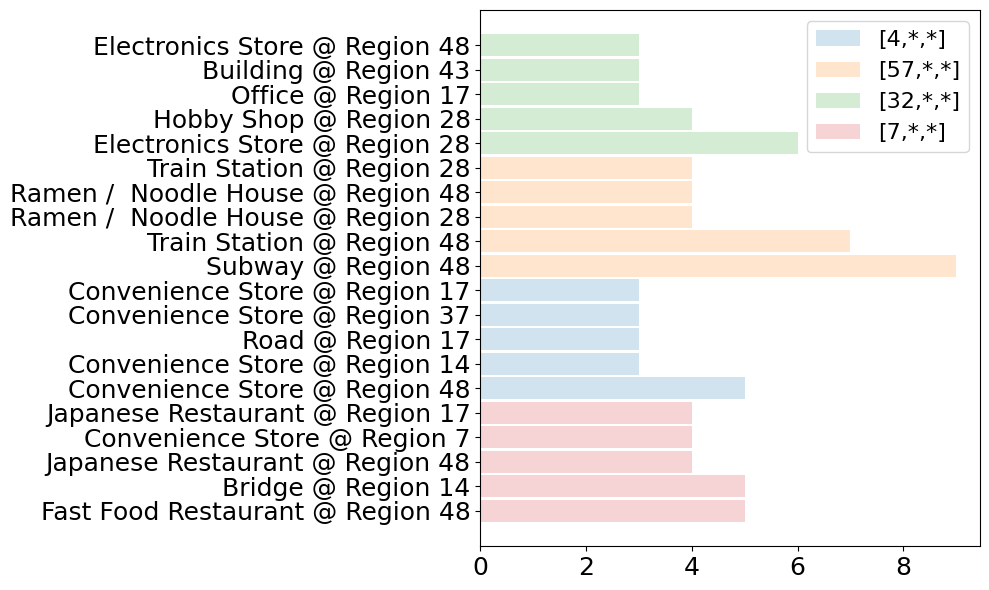

In [43]:
import matplotlib.pyplot as plt

# Create output directory if it doesn't exist
output_dir = f'output/visualization/{target_path}'
os.makedirs(output_dir, exist_ok=True)

# 确保使用与 Cell 3 相同的索引变量
idx1, idx2, idx3, idx4 = selected_indices

# 合并所有的key
all_keys = []
for group in [group_4, group_1, group_2, group_3]:
    for key in group.keys():
        if key not in all_keys:
            all_keys.append(key)
print(all_keys)
# all_keys = sorted(set(group_1.keys()).union(set(group_2.keys())).union(set(group_3.keys()).union(set(group_4.keys()))))
# all_keys = sorted(set(group_1.keys()).union(set(group_2.keys())).union(set(group_3.keys())))

# 获取每个key在各组中的value（若某key不在某组中，视为0）

group_1_values = [group_1.get(key, 0) for key in all_keys]
group_2_values = [group_2.get(key, 0) for key in all_keys]
group_3_values = [group_3.get(key, 0) for key in all_keys]
group_4_values = [group_4.get(key, 0) for key in all_keys]

# 设置条形图位置
x = np.arange(len(all_keys))

# 设置条形图宽度
bar_width = 0.9
alpha = 0.2
# 绘制条形图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每一组的条形图（使用 Cell 3 中的索引变量）
rects1 = ax.barh(x, group_1_values, bar_width, label=f'[{idx1},*,*]', alpha=alpha)
rects2 = ax.barh(x, group_2_values, bar_width, label=f'[{idx2},*,*]', alpha=alpha)
rects3 = ax.barh(x, group_3_values, bar_width, label=f'[{idx3},*,*]', alpha=alpha)
rects4 = ax.barh(x, group_4_values, bar_width, label=f'[{idx4},*,*]', alpha=alpha)

# 添加标签和标题
# ax.set_ylabel('Catname', fontsize=24)
# ax.set_xlabel('Frequency Count', fontsize=24)

ax.set_yticks(x)
ax.set_yticklabels(all_keys, fontsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.legend(fontsize=16)

# 显示图形
# plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_bar.png', dpi=600)
plt.show()






使用索引 [10, 31, 59, 44], 共 713 个 POI
自动收集到 19 个类别+区域组合: ['Convenience Store @ Region 48', 'Japanese Restaurant @ Region 17', 'Convenience Store @ Region 3', 'Japanese Restaurant @ Region 48', 'Food & Drink Shop @ Region 11', 'Food & Drink Shop @ Region 34', 'Ramen /  Noodle House @ Region 43', 'Bridge @ Region 16', 'Convenience Store @ Region 4', 'Train Station @ Region 17', 'Ramen /  Noodle House @ Region 48', 'Food & Drink Shop @ Region 7', 'Arcade @ Region 32', 'Convenience Store @ Region 17', 'Subway @ Region 17', 'College Academic Building @ Region 17', 'Convention Center @ Region 37', 'College Academic Building @ Region 5', 'Mall @ Region 28']
筛选后剩余 50 个 POI


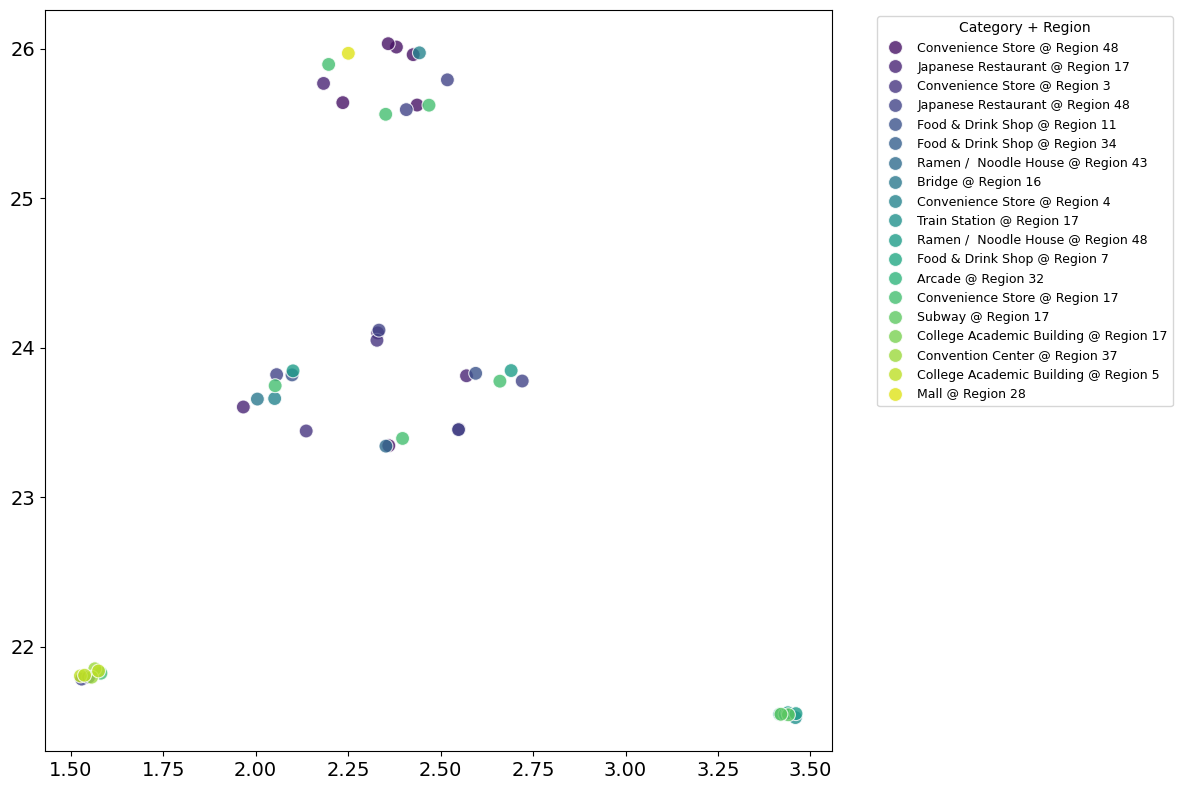

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Use the same codebook data loaded in Cell 0
# codebook is already loaded and merged with poi_info

# 使用 Cell 2 中随机选择的索引
selected_indices = [10, 31, 59, 44]

# Prepare filtered data
# 检查 Vector 列是否已经是列表类型，避免重复 eval
if isinstance(codebook['Vector'].iloc[0], str):
    codebook['Vector'] = codebook['Vector'].apply(eval)
# 使用 selected_indices 中的4个索引
filtered_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx1 or x[0] == idx2 or x[0] == idx3 or x[0] == idx4)] 
print(f"使用索引 {selected_indices}, 共 {len(filtered_df)} 个 POI")

# 自动从四个索引的 top 5 类别+区域组合中收集（去重）
all_keys = []
for idx in selected_indices:
    idx_df = codebook[codebook['Codebook'].apply(lambda x: x[0] == idx)]
    top_cat_regions = idx_df['cat_and_region'].value_counts().head(5).index.tolist()
    for cat_reg in top_cat_regions:
        if cat_reg not in all_keys:
            all_keys.append(cat_reg)
print(f"自动收集到 {len(all_keys)} 个类别+区域组合: {all_keys}")

filtered_df = filtered_df[['cat_and_region', 'Vector']]
filtered_df = filtered_df[filtered_df['cat_and_region'].isin(all_keys)]
print(f"筛选后剩余 {len(filtered_df)} 个 POI")

# 将 `Vector` 列转化为numpy数组，便于t-SNE处理
vectors = np.array(filtered_df['Vector'].to_list())

# 使用t-SNE进行降维到2维
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(vectors)

# 将降维后的结果添加到DataFrame中
filtered_df['tsne_1'] = tsne_results[:, 0]
filtered_df['tsne_2'] = tsne_results[:, 1]

# 颜色按照类别+区域组合排序逐渐变化
# 将类别+区域组合映射到指定顺序并生成颜色
sorted_df = filtered_df[filtered_df['cat_and_region'].isin(all_keys)].copy()
sorted_df['cat_and_region'] = pd.Categorical(sorted_df['cat_and_region'], categories=all_keys, ordered=True)
sorted_df.sort_values('cat_and_region', inplace=True)

# 使用渐变调色板
num_categories = len(all_keys)
palette = sns.color_palette("viridis", num_categories)  # 你可以改为 "plasma", "coolwarm" 等渐变调色板

# 绘制 t-SNE 可视化
fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    data=sorted_df,
    x='tsne_1',
    y='tsne_2',
    hue='cat_and_region',
    palette=palette,
    s=100,
    alpha=0.8,
    ax=ax
)
# plt.title('t-SNE Visualization with Gradual Color Transition', fontsize=16)
ax.set_xlabel('') # 显示设置为空字符串 t-SNE 1
ax.set_ylabel('') # t-SNE 2
ax.legend(title='Category + Region', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9) # 放到图右侧
ax.tick_params(axis='y', labelsize=14)  
ax.tick_params(axis='x', labelsize=14)
plt.tight_layout()
plt.savefig(f'{output_dir}/semitic_tsne_cat_region.png', dpi=600, bbox_inches='tight')
plt.show()
